In [1]:
!pwd

/orfeo/cephfs/home/dssc/adellasiega/XAI_Monuments


In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import keras

2024-11-19 10:30:44.639056: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 10:30:44.654017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732008644.672048 1469599 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732008644.677551 1469599 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 10:30:44.697165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
def load_detector(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)  
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 91 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

detector = load_detector(num_classes).to(device)

model_path = "./model/model_monumenai.pth"
detector.load_state_dict(torch.load(model_path, map_location=device))
detector.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),         
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)


image_paths = [
    "./Data/Dataset-IGRB1092_14cls/01.musulman/medina_azahara14.jpg",
    "./Data/Dataset-IGRB1092_14cls/02.gotico/torre_fadrique3.jpg",
    "./Data/Dataset-IGRB1092_14cls/03.renacentista/palacio_carlos_v_granada19.jpg",
    "./Data/Dataset-IGRB1092_14cls/04.barroco/convento_carmelitas_descalzas_granada6.jpg",
    "./Data/Dataset-IGRB1092_14cls/04.barroco/20181212_105011.jpg"

]

input_images = [preprocess_image(img_path).to(device) for img_path in image_paths]

with torch.no_grad():
    outputs = detector(input_images)

for idx, output in enumerate(outputs):
    print(f"Risultati per immagine {idx + 1}:")
    print("Bounding boxes:", output["boxes"])
    print("Classi:", output["labels"])
    print("Punteggi:", output["scores"])

/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,


Risultati per immagine 1:
Bounding boxes: tensor([[3.4186e+02, 2.2370e+02, 4.7986e+02, 3.6490e+02],
        [1.0196e+02, 2.5859e+02, 1.9929e+02, 3.6846e+02],
        [2.1260e+02, 2.3652e+02, 3.2897e+02, 3.7376e+02],
        [3.2759e+02, 1.2213e+02, 5.0045e+02, 2.3505e+02],
        [8.7795e+01, 1.9284e+02, 2.1585e+02, 3.7609e+02],
        [1.2851e+01, 6.1380e+00, 5.3311e+02, 1.3237e+02],
        [3.2049e+02, 1.2229e+02, 4.8582e+02, 2.2845e+02],
        [9.0646e+01, 1.6437e+02, 2.1251e+02, 2.6536e+02],
        [2.0476e+02, 1.4461e+02, 3.3024e+02, 2.1876e+02],
        [2.0264e+02, 1.4511e+02, 3.2976e+02, 2.3357e+02],
        [1.2354e+02, 0.0000e+00, 5.1290e+02, 9.2572e+01],
        [9.4132e+01, 1.6891e+02, 2.0891e+02, 2.5337e+02],
        [2.0636e+02, 1.4285e+02, 3.2967e+02, 2.6335e+02],
        [3.2114e+02, 1.4178e+02, 5.0509e+02, 3.7006e+02],
        [3.3295e+02, 1.1895e+02, 5.0028e+02, 2.3910e+02],
        [3.5156e+02, 1.0164e+02, 4.8087e+02, 1.3498e+02],
        [9.7342e+01, 4.5242e-0

In [4]:
def extract_features(detector, input_images):
    """
    Estrae feature numeriche dalle immagini originali usando il backbone del detector.
    """
    detector.eval()
    with torch.no_grad():
        # Ottieni i risultati del detector
        outputs = detector(input_images)

        # Lista per salvare le feature estratte
        features_list = []

        # Itera sulle immagini
        for idx, output in enumerate(outputs):
            boxes = output["boxes"]
            labels = output["labels"]
            scores = output["scores"]

            # Usa solo le regioni con punteggi sufficientemente alti
            high_score_indices = scores > 0.5
            filtered_boxes = boxes[high_score_indices]
            filtered_labels = labels[high_score_indices]

            # Calcola una rappresentazione numerica per ogni box
            # Qui potresti aggiungere un estrattore di feature specifico
            # Per esempio, media dei valori pixel, oppure usare il backbone del detector
            features = []
            for box in filtered_boxes:
                cropped_image = input_images[idx][:, int(box[1]):int(box[3]), int(box[0]):int(box[2])]
                # Calcola qualche statistica o passa il crop in un modello
                features.append(cropped_image.mean().item())  # Dummy: usa feature più significative

            features_list.append(features)

        return features_list
# Prepara le feature per il classificatore
features = extract_features(detector, input_images)

# Assumi che ogni immagine produca un array di dimensioni compatibili con il classificatore
# Puoi usare padding o altre tecniche per uniformare la lunghezza
prepared_features = np.zeros((len(features), 17))  # Supponendo che il classificatore si aspetti 17 feature
for i, feat in enumerate(features):
    prepared_features[i, :len(feat)] = feat[:17]  # Trunca o pad per uniformare


In [5]:
# Passa le feature al classificatore
num_archi_features = 17
classificator = keras.Sequential()
classificator.add(keras.layers.Dense(units=11, activation='relu', input_shape=(num_archi_features,)))
classificator.add(keras.layers.Dense(units=4, activation='softmax'))
classificator.load_weights("model/classificator.weights.h5")

/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1732008649.734090 1469599 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
predicted_probabilities = classificator.predict(prepared_features)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

styles_map = {0: "Hispanic-muslim", 1: "Gotic", 2: "Renaissance", 3: "Baroque"}
for i, pred_class in enumerate(predicted_classes):
    print(f"Immagine {i + 1}: Stile predetto: {styles_map[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Immagine 1: Stile predetto: Hispanic-muslim
Immagine 2: Stile predetto: Gotic
Immagine 3: Stile predetto: Hispanic-muslim
Immagine 4: Stile predetto: Gotic
Immagine 5: Stile predetto: Renaissance


In [7]:
def predict_style_with_explanations(detector, classificator, image_path, threshold=0.5, styles_map=None):
    # Preprocessa l'immagine
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0).to(next(detector.parameters()).device)

    # Ottieni i risultati del detector
    detector.eval()
    with torch.no_grad():
        outputs = detector(input_image)

    boxes = outputs[0]["boxes"]
    scores = outputs[0]["scores"]
    labels = outputs[0]["labels"]

    # Filtra le bounding box con punteggio sopra il threshold
    high_score_indices = scores > threshold
    filtered_boxes = boxes[high_score_indices]
    filtered_scores = scores[high_score_indices]
    filtered_labels = labels[high_score_indices]

    # Prepara le feature basandoti sui riquadri selezionati
    features = []
    for box in filtered_boxes:
        x_min, y_min, x_max, y_max = box.int().cpu().numpy()
        cropped_image = input_image[0, :, y_min:y_max, x_min:x_max]
        feature = cropped_image.mean().item()  # Dummy: sostituire con feature più significative
        features.append(feature)

    # Pad/Tronca le feature per adattarle al classificatore
    max_features = classificator.input_shape[-1]  # Supponendo input_shape di Keras
    prepared_features = np.zeros((1, max_features))
    prepared_features[0, :len(features)] = features[:max_features]

    # Predici lo stile
    predicted_probabilities = classificator.predict(prepared_features)
    predicted_class = np.argmax(predicted_probabilities, axis=1)[0]
    predicted_style = styles_map[predicted_class] if styles_map else predicted_class

    # SHAP per interpretare
    explainer = shap.KernelExplainer(classificator.predict, prepared_features)
    shap_values = explainer.shap_values(prepared_features, nsamples=30)

    return image, filtered_boxes.cpu().numpy(), shap_values, predicted_style


In [8]:
def visualize_explanations(image, boxes, shap_values, predicted_style, styles_map=None):
    shap_scores = np.array([abs(val) for val in shap_values[0][0]])  # Assumi SHAP per la prima classe
    
    # Gestisci mismatch tra SHAP e riquadri
    if len(shap_scores) < len(boxes):
        print("Avviso: meno valori SHAP rispetto ai riquadri. Riempiendo con zero.")
        shap_scores = np.pad(shap_scores, (0, len(boxes) - len(shap_scores)), constant_values=0)
    
    elif len(shap_scores) > len(boxes):
        print("Avviso: più valori SHAP rispetto ai riquadri. Troncando.")
        shap_scores = shap_scores[:len(boxes)]
        
    # Mostra immagine con riquadri
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Sovrapponi i riquadri
    shap_scores = shap_scores / shap_scores.max()  # Normalizza
    for i, box in enumerate(boxes):
        print(box)
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=5, edgecolor=plt.cm.Reds(0.7), facecolor='none')
        ax.add_patch(rect)
        
    # Predizione
    title = f"Predizione dello stile: {predicted_style}"
    ax.set_title(title, fontsize=16)
    plt.axis("off")
    plt.show()

In [9]:
styles_map = {0: "Hispanic-muslim", 1: "Gotic", 2: "Renaissance", 3: "Baroque"}
image_path = "./Data/Dataset-IGRB1092_14cls/03.renacentista/palacio_carlos_v_granada19.jpg"

image, boxes, shap_values, predicted_style = predict_style_with_explanations(
    detector, classificator, image_path, threshold=0.5, styles_map=styles_map
)
print(shap_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.23it/s]

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


Avviso: meno valori SHAP rispetto ai riquadri. Riempiendo con zero.
[ 600.7244   911.29236  993.0469  1448.1455 ]
[141.79872 327.12366 345.55792 620.7684 ]
[1251.0934   327.71182 1449.8113   628.07404]
[ 110.90108  976.6746   305.22043 1222.7906 ]
[1294.3964   974.75934 1492.0753  1256.2319 ]
[ 549.69116  746.20526 1031.9462   912.7119 ]
[541.1315  204.10873 689.3917  474.64352]
[151.39044 751.20844 288.2448  893.8466 ]
[ 546.9762    67.31366 1041.4585   585.81213]
[657.45404   86.654495 953.9676   285.46902 ]
[1309.3671  760.0716 1457.9983  897.7469]
[1285.8455    99.70056 1413.9663   242.74771]
[194.42892  93.04564 333.7841  224.75749]
[  0.      228.27148  81.1777  301.16965]
[  1.3290193 313.65814    54.487656  603.1713   ]
[ 519.21014  752.2967  1064.6011   942.9175 ]
[192.32715   93.769646 329.56195  218.55614 ]


/tmp/ipykernel_1469599/4099072713.py:18: RuntimeWarning: invalid value encountered in divide
  shap_scores = shap_scores / shap_scores.max()  # Normalizza


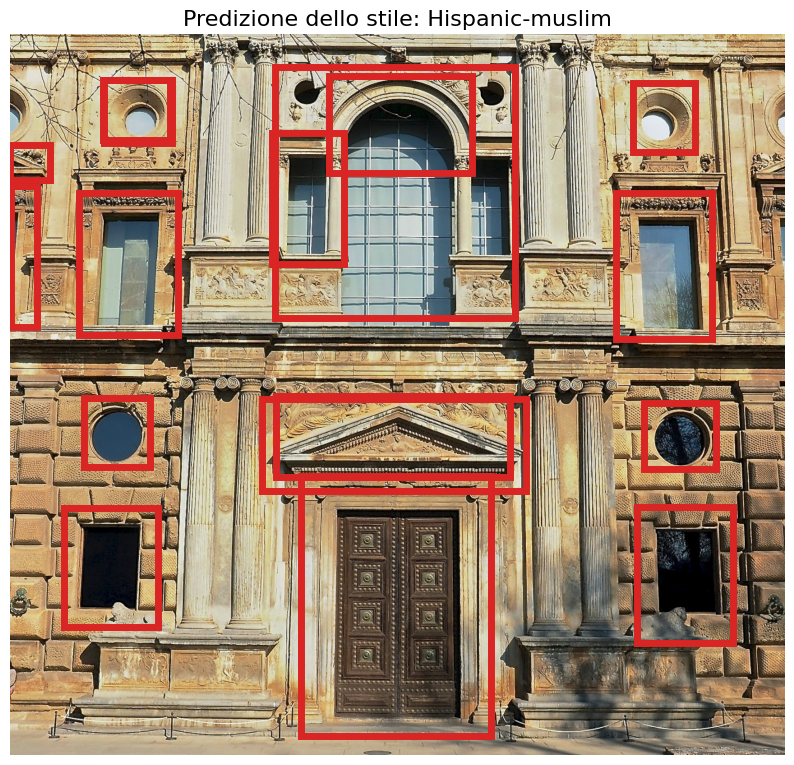

In [10]:
visualize_explanations(image, boxes, shap_values, predicted_style, styles_map=styles_map)